# Import Library

In [6]:
# Basic Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Get Dataset Liblary
import os
from os.path import join

# Visualization Liblary
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import plotly.graph_objects as go

# Preprocessing
import re

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel

# Import Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahlevi20","key":"f9eba01a9c284de7e66f83e345bd561b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


# Import Dataset

In [4]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 36% 9.00M/25.0M [00:00<00:00, 45.7MB/s]
100% 25.0M/25.0M [00:00<00:00, 83.5MB/s]


In [5]:
!unzip anime-recommendations-database.zip -d anime-recommendations-database

Archive:  anime-recommendations-database.zip
  inflating: anime-recommendations-database/anime.csv  
  inflating: anime-recommendations-database/rating.csv  


In [35]:
df1 = pd.read_csv('/content/anime-recommendations-database/anime.csv')

# Exploratory Data Analysis

Disini saya melakukan Eksplorasi Data Analyis (EDA) dan Data Cleaning untuk memeriksa dataset yang akan saya training. Tujuannya adalah untuk melihat isi dari dataset tersebut apakah ada yang perlu dibuang atau tidak, apakah ada NaN, melihat tipe datanya, melihat jumlah kolom dan baris dan lainnya.

In [36]:
print('===================EXPLORATORY DATA ANALYSIS=================================')
long_string='========================================================================'
def printByInformation(dataset, option=False):
  if option:
    pd.set_option('display.max_columns',None)
    print(f'current rows:{dataset.shape[0]}')
    print(f'current col:{dataset.shape[1]}')
    print(long_string)
    print('======================DATA CLEANING=======================================')
    print(f'jumlah NaN {dataset.isnull().sum().sum()} dari NaN yg ditemukan')
    print(long_string)
    print(f'jumlah NaN tiap Column\n{dataset.isnull().sum()}')
    print(long_string)
    print(f'Name Columns: {list(dataset.columns)}')
    print(long_string)
    print(f'{dataset.info()}')
    print(long_string)
    print(f'{dataset.describe()}')
printByInformation(df1,True)
  

===================EXPLORATORY DATA ANALYSIS=================================
current rows:12294
current col:7
======================DATA CLEANING=======================================
jumlah NaN 317 dari NaN yg ditemukan
jumlah NaN tiap Column
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
Name Columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None
           anime

Dataset yang dipakai adalah [Anime Recommendations Database](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=anime.csv)
yang memiliki 320.000 users dan 16.000 anime dari [myanimelist.net](https://myanimelist.net/)

anime data:
* anime_id - kode unik untuk mengindentifikasi setiap anime
* name - judul dari anime
* genre - list genre yang dipisahkan tanda koma untuk setiap anime.
* type - tipe dari anime
* episodes - berapa banyak episode dari anime. (1 jika movie).
* rating - rating rata-rata dari 10.
* members - jumlah anggota komunitas yang ada di "grup" anime.

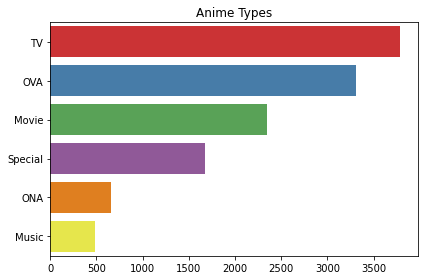

In [37]:
type_count = df1['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='Set1').set_title('Anime Types')

plt.tight_layout()
plt.show()

Insight yang saya dapatkan disni adalah:
- Anime Types "TV" yang paling banyak dibandingkan tipe lain
- Anime Types "Music" yang paling sedikit dibandingkan tipe lain

In [38]:
df1_data=df1.copy()

Melakukan duplikasi data

# Data Cleaning

In [39]:
null_features = df1_data.columns[df1_data.isna().any()]
df1_data[null_features].isna().sum()

genre      62
type       25
rating    230
dtype: int64

In [40]:
df1_data.dropna(inplace=True)
df1_data[null_features].isna().sum()

genre     0
type      0
rating    0
dtype: int64

karena data memiliki NaN maka saya membuang data yang mempunyai NaN

# Text Cleaning

selanjutnya saya melakukan text cleaning pada kolom **name** dengan cara menggunakan teknik Regex lalu saya membuat function yang bernama text cleaning dan mengaplikasikannya pada df1_data

In [41]:
df1_data['name'].unique()[3:10]

array(['Steins;Gate', 'Gintama&#039;',
       'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
       'Gintama&#039;: Enchousen'], dtype=object)

In [42]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    return text

selanjutnya saya membuat function dengan nama text_cleaning dengan tujuannya yaitu untuk menghilangkan simbol atau text yang tidak diperlukan

In [43]:
df1_data['name'] = df1_data['name'].apply(text_cleaning)

In [44]:
df1_data['name'].unique()[0:10]

array(['Kimi no Na wa.', 'Fullmetal Alchemist: Brotherhood', 'Gintama°',
       'Steins;Gate', 'Gintama',
       'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
       'Gintama: Enchousen'], dtype=object)

# Modeling
Selanjutnya ini adalah tahap modeling saya menggunakan teknik sistem rekomendasi content based filtering. 

Di sini saya akan menggunakannya genre, sehingga saya dapat merekomendasikan pengguna berdasarkan konten genre.

- Disini saya menggunakan **TF-IDF Vectorizer** sebagai model yang digunakan untuk menemukan representasi fitur penting dari setiap genre anime.

In [45]:
# Inisialisasi TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None,
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      stop_words = 'english')

In [46]:
genres_str = df1_data['genre'].str.split(',').astype(str)

In [47]:
genres_str

0        ['Drama', ' Romance', ' School', ' Supernatural']
1        ['Action', ' Adventure', ' Drama', ' Fantasy',...
2        ['Action', ' Comedy', ' Historical', ' Parody'...
3                                  ['Sci-Fi', ' Thriller']
4        ['Action', ' Comedy', ' Historical', ' Parody'...
                               ...                        
12289                                           ['Hentai']
12290                                           ['Hentai']
12291                                           ['Hentai']
12292                                           ['Hentai']
12293                                           ['Hentai']
Name: genre, Length: 12017, dtype: object

In [48]:
tfv_matrix = tfv.fit_transform(genres_str)

In [49]:
tfv_matrix

<12017x1547 sparse matrix of type '<class 'numpy.float64'>'
	with 84086 stored elements in Compressed Sparse Row format>

## Sigmoid Kernel
Selanjutnya kita perlu menetapkan 1 sebagai tanda anime yang direkomendasikan dan 0 sebagai anime yang tidak direkomendasikan. Dengan begitu saya menggunakan kernel sigmoid karena paling cocok untuk hasil binary

In [50]:
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [51]:
sig

array([[0.7618655 , 0.7616004 , 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.7616004 , 0.7618655 , 0.76160105, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76160105, 0.7618655 , ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76159416, 0.76159416, ..., 0.7618655 , 0.7618655 ,
        0.7618655 ],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.7618655 , 0.7618655 ,
        0.7618655 ],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.7618655 , 0.7618655 ,
        0.7618655 ]])

In [52]:
indices = pd.Series(df1_data.index, index=df1_data['name']).drop_duplicates()

## Membuat Recomendation Function
Selanjutnya membuat fungsi untuk mendapatkan rekomendasi anime. dengan cara kerja mengubah skor kesamaan menjadi list menggunakan fungsi enumerate, lalu mengurutkan daftar dan memilih 10 skor teratas untuk direkomendasikan dan menghapus data yang dicari agar tidak dimunculkan dalam list rekomendasi

In [53]:
def get_recomendation(title, sig=sig):
    # mendapatkan indeks yang sesuai dengan original_title
    idx = indices[title]

    # mendapatkan skor kesamaan berpasangan
    sig_scores = list(enumerate(sig[idx]))

    # urutkan film
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # mendapatkan skor dari 10 film yang paling mirip
    sig_scores = sig_scores[0:11]

    # indeks film
    anime_indices = [i[0] for i in sig_scores]

    # Drop nama anime yang dicari agar tidak muncul dalam daftar rekomendasi
    anime_indices = [t for t in anime_indices if t != idx]

    # mengembalikan nilai 10 film paling mirip
    return pd.DataFrame({'Anime name': df1_data['name'].iloc[anime_indices].values,
                         'Genre': df1_data['genre'].iloc[anime_indices].values,
                         'Rating': df1_data['rating'].iloc[anime_indices].values})

# Evaluation
Untuk mengevaluasi model saya melakukan uji coba langsung dengan memanggil fungsi yang sudah saya buat dan memasukan judul anime yang pengguna suka sebelumnya.

In [54]:
print("rekomendasi anime untuk One Piece")
get_recomendation('One Piece')

rekomendasi anime untuk One Piece


,Anime name,Genre,Rating
0,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.29
1,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.27
2,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.78
3,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.42
4,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.39
5,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.32
6,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.75
7,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.25
8,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.65
9,Digimon Savers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.10


In [55]:
feature_recomendation = get_recomendation('One Piece')

In [56]:
feature = df1_data[df1_data['name'] == 'One Piece']

In [57]:
feature

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862


In [58]:
get_feature_genre=[]
for i in range(len(feature.genre)):
    for x in feature.genre.str.split(','):
        if x not in get_feature_genre:
            get_feature_genre.append(x)

In [59]:
get_feature_genre

[['Action',
  ' Adventure',
  ' Comedy',
  ' Drama',
  ' Fantasy',
  ' Shounen',
  ' Super Power']]

In [60]:
feature_recomendation

,Anime name,Genre,Rating
0,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.29
1,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.27
2,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.78
3,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.42
4,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.39
5,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.32
6,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.75
7,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.25
8,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.65
9,Digimon Savers,"Adventure, Comedy, Drama, Fantasy, Shounen",7.10


In [61]:
for i in get_feature_genre[0]:
  print(i + ": " + str((
      (feature_recomendation['Genre'].str.contains(i).count()/feature_recomendation['Genre'].count())*100)
  ))

Action: 100.0
 Adventure: 100.0
 Comedy: 100.0
 Drama: 100.0
 Fantasy: 100.0
 Shounen: 100.0
 Super Power: 100.0


disini dapat kita lihat bahwa sistem rekomendasi memberitahu bahwa genre terebut 100.0 atau 100% akurat benar